This notebook uses the final dataset with higher variance kernel and final material properties. This notebook also swaps out optimizer for SGD.

In [1]:
# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime
import hashlib

# Scientific computing
import numpy as np
import scipy as sp

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import (
    DataLoader, Dataset, TensorDataset,
    random_split, ConcatDataset
)
from torchvision import transforms

# Neural operator specific
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer, LpLoss, H1Loss

# Data processing and visualization
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Progress tracking
from tqdm import tqdm

In [2]:
# Force garbage collection to release file handles
import gc
gc.collect()

291

## Load and visualize data

In [3]:
current_dir = os.getcwd()
reduced_dataset_paths = []

# Number of sets and datasets per set
set_num = 8
set_size = 20  # 20 continuous + 20 binarized = 40 datasets per set

# Add all datasets from each set folder
# Structure: data/train/set {set_idx}/out_continuous_{i}/ and out_binarized_{i}/
for set_idx in range(1, set_num + 1):
    for i in range(1, set_size + 1):
        # Add continuous dataset path
        # Path format: data/train/set {set_idx}/out_continuous_{i}/
        path_c = os.path.join(current_dir, 'data', 'train', f'set {set_idx}', f'out_continuous_{i}')
        reduced_dataset_paths.append(path_c)
        # Add binary dataset path
        # Path format: data/train/set {set_idx}/out_binarized_{i}/
        path_b = os.path.join(current_dir, 'data', 'train', f'set {set_idx}', f'out_binarized_{i}')
        reduced_dataset_paths.append(path_b)

# Define dataset constants
num_geometries_per_dataset = 150
num_geometries = num_geometries_per_dataset * len(reduced_dataset_paths)
num_waveforms = 91 #strict IBZ reduced wavevector count from 325 to 91
num_band_ffts = 6
num_displacements = 4
waveform_reduction_ratio = 60/91
band_fft_reduction_ratio = 3/6
num_reduced_indices = int(num_geometries * num_waveforms * waveform_reduction_ratio * num_band_ffts * band_fft_reduction_ratio)
num_datasets = len(reduced_dataset_paths)
print('Expected total number of reduced indices (samples):', num_reduced_indices)

# Preallocate the final tensors
combined_geometries = torch.empty((num_geometries, 32, 32))
combined_displacements = torch.empty((num_reduced_indices, 4, 32, 32))
combined_reduced_indices = torch.empty((num_reduced_indices, 3), dtype=torch.long)

# Load waveforms and bands only once (from first dataset)
print("Loading waveforms and bands (same across all datasets)...")
waveforms = torch.load(os.path.join(reduced_dataset_paths[0], 'waveforms_full.pt'), weights_only=False)
band_ffts = torch.load(os.path.join(reduced_dataset_paths[0], 'band_fft_full.pt'), weights_only=False)
print(f"Waveforms - dtype: {waveforms.dtype}, shape: {waveforms.shape}")
print(f"Band FFTs - dtype: {band_ffts.dtype}, shape: {band_ffts.shape}")

# Load all datasets and copy directly into preallocated tensors
geom_offset = 0
sample_offset = 0

for i, dataset_path in enumerate(reduced_dataset_paths):
    print(f"Loading dataset {i+1} from {dataset_path}")
    
    # Load only the dataset-specific components
    geometries = torch.load(os.path.join(dataset_path, 'geometries_full.pt'), weights_only=False)
    displacements = torch.load(os.path.join(dataset_path, 'displacements_dataset.pt'), weights_only=False)
    reduced_indices = torch.load(os.path.join(dataset_path, 'reduced_indices.pt'), weights_only=False)
    # Convert to tensor if it's a list of tuples
    if isinstance(reduced_indices, list):
        reduced_indices = torch.tensor(reduced_indices, dtype=torch.long)
    elif isinstance(reduced_indices, torch.Tensor):
        # Ensure it's the right dtype
        reduced_indices = reduced_indices.long()
    
    # Apply geometry index offset: +1200*(dataset_number-1)
    geometry_offset = num_geometries_per_dataset * i
    reduced_indices[:, 0] += geometry_offset
    
    # Stack displacements
    stacked_displacements = torch.stack([
        displacements.tensors[0],  # [samples, 32, 32]
        displacements.tensors[1],  # [samples, 32, 32]
        displacements.tensors[2],  # [samples, 32, 32]
        displacements.tensors[3]   # [samples, 32, 32]
    ], dim=1)  # [samples, 4, 32, 32]
    
    # Copy directly into preallocated tensors
    combined_geometries[geom_offset:geom_offset+num_geometries_per_dataset] = geometries
    combined_displacements[sample_offset:sample_offset+len(reduced_indices)] = stacked_displacements
    combined_reduced_indices[sample_offset:sample_offset+len(reduced_indices)] = reduced_indices
    
    # Update offsets
    geom_offset += num_geometries_per_dataset
    sample_offset += len(reduced_indices)
    
    # The loaded tensors (geometries, displacements, reduced_indices) are automatically
    # garbage collected since we don't store references to them

# waveforms and band_ffts are already loaded and don't need concatenation
print(f"Final dataset shapes:")
print(f"  - Geometries: {combined_geometries.shape}")
print(f"  - Waveforms: {waveforms.shape}")
print(f"  - Band FFTs: {band_ffts.shape}")
print(f"  - Displacements: {combined_displacements.shape}")
print(f"  - Reduced indices: {combined_reduced_indices.shape}")

Expected total number of reduced indices (samples): 8640000
Loading waveforms and bands (same across all datasets)...
Waveforms - dtype: torch.float16, shape: torch.Size([91, 32, 32])
Band FFTs - dtype: torch.float16, shape: torch.Size([6, 32, 32])
Loading dataset 1 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_continuous_1
Loading dataset 2 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_binarized_1
Loading dataset 3 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_continuous_2
Loading dataset 4 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_binarized_2
Loading dataset 5 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_continuous_3
Loading dataset 6 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_binarized_3
Loading dataset 7 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_continuous_4
Loading dataset 8 from d:\Research\NO-2D-Metamaterials\data\train\set 1\out_binarized_4
Loading dataset 9 from d:\Research\NO-2D-Me

## Sanity Checks on Dataset Imports

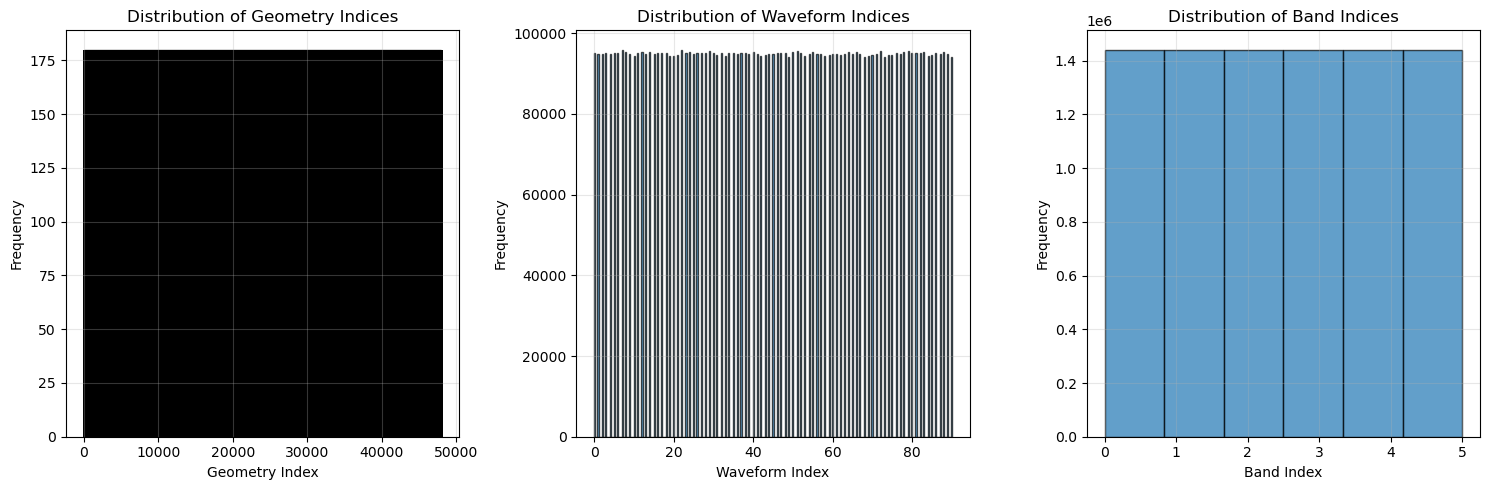

Geometry indices - Min: 0, Max: 47999, Unique: 48000
Waveform indices - Min: 0, Max: 90, Unique: 91
Band indices - Min: 0, Max: 5, Unique: 6


In [4]:
# Create histograms for the three values in combined_reduced_indices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Extract the three columns
geom_indices = combined_reduced_indices[:, 0].numpy()
waveform_indices = combined_reduced_indices[:, 1].numpy() 
band_indices = combined_reduced_indices[:, 2].numpy()

# Plot histogram for geometry indices
axes[0].hist(geom_indices, bins=num_geometries, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Geometry Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Geometry Indices')
axes[0].grid(True, alpha=0.3)

# Plot histogram for waveform indices
axes[1].hist(waveform_indices, bins=325, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Waveform Index')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Waveform Indices')
axes[1].grid(True, alpha=0.3)

# Plot histogram for band indices
axes[2].hist(band_indices, bins=6, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Band Index')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Band Indices')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Geometry indices - Min: {geom_indices.min()}, Max: {geom_indices.max()}, Unique: {len(np.unique(geom_indices))}")
print(f"Waveform indices - Min: {waveform_indices.min()}, Max: {waveform_indices.max()}, Unique: {len(np.unique(waveform_indices))}")
print(f"Band indices - Min: {band_indices.min()}, Max: {band_indices.max()}, Unique: {len(np.unique(band_indices))}")


In [5]:
def visualize_sample(sample_number, GWB_indices, geometries, waveforms, bands, displacements):
    """
    Visualize input and output tensors from a single sample.
    
    Args:
        sample_number: Index to select a specific sample
        GWB_indices: Tensor of shape (N, 3) containing geometry, waveform, and band indices
        geometries: Tensor containing geometry data
        waveforms: Tensor containing waveform data
        bands: Tensor containing band data
        displacements: Tensor of shape (N, 4, 32, 32) containing output components
    """
    # Get the GWB index for this sample
    gwb_index = GWB_indices[sample_number]  # Shape (3,)
    
    # Extract individual indices
    geom_idx = gwb_index[0].item()
    waveform_idx = gwb_index[1].item()
    band_idx = gwb_index[2].item()
    
    # Get the corresponding geometry, waveform, and band
    geometry = geometries[geom_idx]
    waveform = waveforms[waveform_idx]
    band = bands[band_idx]
    
    # Stack them to create input_tensor equivalent
    input_tensor = torch.stack([geometry, waveform, band], dim=0)
    
    # Get the displacement for this sample
    displacement = displacements[sample_number]  # Shape (4, 32, 32)
    
    # Create figure for input components
    fig1 = plt.figure(figsize=(12, 4))

    # Plot input tensor components (1x3 subplot)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        im = plt.imshow(input_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Input Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for output components 
    fig2 = plt.figure(figsize=(16, 4))

    # Plot output tensor components (1x4 subplot)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        im = plt.imshow(displacement[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Output Component {i+1}')

    plt.tight_layout()
    plt.show()

Visualizing random sample 8520746


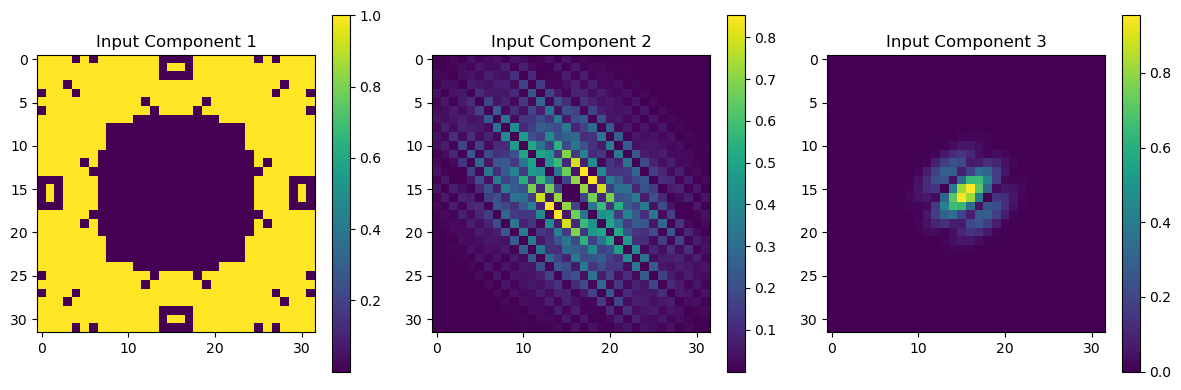

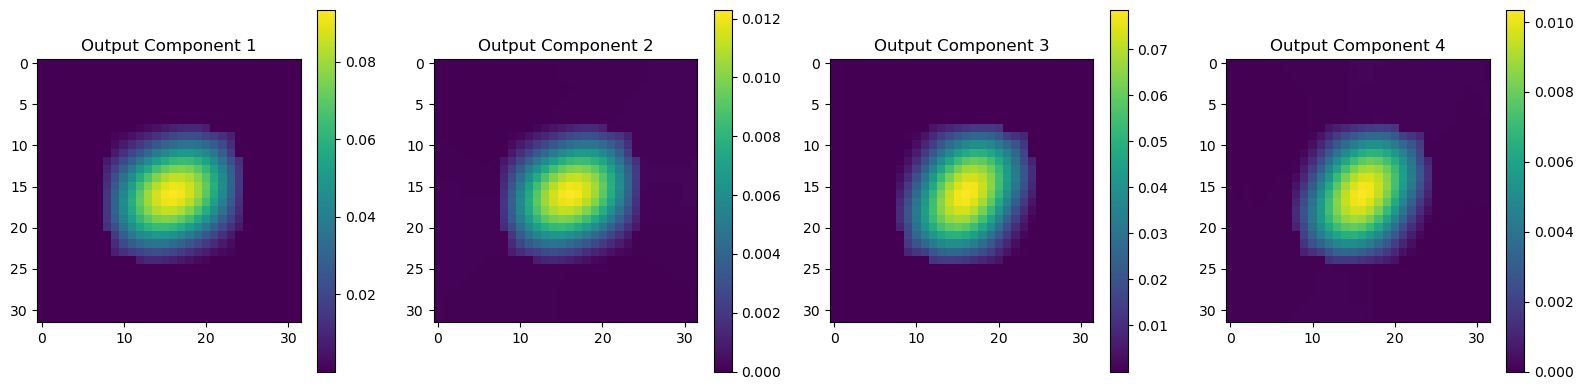

In [6]:
# Get a random sample from the dataset
random_idx = np.random.randint(0, len(combined_reduced_indices))
print(f"Visualizing random sample {random_idx}")
visualize_sample(random_idx, combined_reduced_indices, combined_geometries, waveforms, band_ffts, combined_displacements)

## Assemble Dataloader for Model Training

In [7]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
split_generator = torch.Generator().manual_seed(SEED)

print("Creating indices only dataset...")
start_time = time.time()
sample_indices = torch.arange(len(combined_reduced_indices))
dataset = torch.utils.data.TensorDataset(sample_indices)
print(f"Dataset creation took: {time.time() - start_time:.2f} seconds")

print("Splitting dataset...")
start_time = time.time()
# Split dataset
train_size = int(0.98 * len(dataset))
test_size = int(0.02 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=split_generator
)
print(f"Dataset splitting took: {time.time() - start_time:.2f} seconds")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print("Creating DataLoaders...")
start_time = time.time()
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True, 
    num_workers=6,  # Use 6-8 workers for 16-core CPU
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=2  # Prefetch 2 batches per worker
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=256, 
    shuffle=False, 
    num_workers=6,  # Use 6-8 workers for 16-core CPU
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=2  # Prefetch 2 batches per worker
)
print(f"DataLoader creation took: {time.time() - start_time:.2f} seconds")

Creating indices only dataset...
Dataset creation took: 0.02 seconds
Splitting dataset...
Dataset splitting took: 0.64 seconds
Train dataset size: 8467200
Test dataset size: 172800
Creating DataLoaders...
DataLoader creation took: 0.00 seconds


## Model architecture & training

In [8]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels, out_channels, hidden, num_layers):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         n_modes_height=self.modes_height, 
                         n_modes_width=self.modes_width, 
                         hidden_channels=self.hidden, 
                         n_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

Using Device: cuda
Using PyTorch version: 2.5.1


In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=128):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    
    progress_bar = tqdm(enumerate(loader), total=total_batches, 
                       desc=f"Epoch {epoch + 1}", 
                       unit="batch")
    
    for batch_idx, (batch_indices,) in progress_bar:
        # Fetch data using indices
        batch_size = len(batch_indices)
        batch_inputs = [None] * batch_size
        batch_targets = [None] * batch_size
        
        for i, idx in enumerate(batch_indices):
            geometry_idx, waveform_idx, band_idx = combined_reduced_indices[idx]
            
            # Use a training case index to access the correct tensors
            geometry = combined_geometries[geometry_idx]
            waveform = waveforms[waveform_idx]
            band_fft = band_ffts[band_idx]
            target = combined_displacements[idx]
            
            input_tensor = torch.stack([geometry, waveform, band_fft], dim=0)
            batch_inputs[i] = input_tensor
            batch_targets[i] = target
        
        # Move to GPU and train
        batch_inputs = torch.stack(batch_inputs).to(device)
        batch_targets = torch.stack(batch_targets).to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets).mean()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_inputs.size(0)
        
        if (batch_idx + 1) % report_freq == 0:
            progress_bar.set_postfix(batch_loss=f"{loss.item():.6f}")
    
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_batches = len(loader)
    
    progress_bar = tqdm(enumerate(loader), total=total_batches, 
                       desc="Evaluating", 
                       unit="batch")
    
    with torch.no_grad():
        for batch_idx, (batch_indices,) in progress_bar:
            # Fetch data using indices (same as training)
            batch_inputs = []
            batch_targets = []
            
            for idx in batch_indices:
                geometry_idx, waveform_idx, band_idx = combined_reduced_indices[idx]
                
                # Use a training case index to access the correct tensors
                geometry = combined_geometries[geometry_idx]
                waveform = waveforms[waveform_idx]
                band_fft = band_ffts[band_idx]
                target = combined_displacements[idx]
                
                input_tensor = torch.stack([geometry, waveform, band_fft], dim=0)
                batch_inputs.append(input_tensor)
                batch_targets.append(target)
            
            # Move to GPU (same as training)
            batch_inputs = torch.stack(batch_inputs).to(device)
            batch_targets = torch.stack(batch_targets).to(device)
            
            # Forward pass (no backward pass in evaluation)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets).mean()
            
            running_loss += loss.item() * batch_inputs.size(0)
            
            # Update progress bar
            progress_bar.set_postfix(batch_loss=f"{loss.item():.6f}")
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [26]:
hc = 128
layers = 4
lr = 1e-2        
momentum = 0.9   
nesterov = True  # Nesterov momentum
wd = 0        # L2 regularization
ss = 1           # Step size for multi-epoch SGD schedules
gamma = 0.9      # Multiplicative factor for StepLR
design_res = 32

model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc, num_layers=layers).to(device)
#model = model.half()
model = model.to(device)
criterion = nn.MSELoss(reduction='mean') # Use mean squared error loss
#criterion = criterion.half()

# Define the SGD optimizer with best practices
optimizer = optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=wd,
    nesterov=nesterov
)

# Recommended: Step the LR down every 30 epochs by 0.1 for SGD
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ss, gamma=gamma)

# Parameters for saving/loading model weights
save_path = f'./bcdr_f16_L2SGD_hc{hc}_lr{lr:.0e}_wd{wd:.0e}_ss{ss}_gamma{gamma:.0e}.pth'
print(save_path)
load_existing_model = False  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(save_path):
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded model weights from {save_path}")

# Lists to store losses for plotting
train_losses = []
val_losses = []

./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01.pth


Evaluating: 100%|██████████| 675/675 [01:17<00:00,  8.75batch/s, batch_loss=0.000239]


Epoch 1/8, Training Loss: 0.0002411214, Validation Loss: 0.0002393277
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch1.pth


Evaluating: 100%|██████████| 675/675 [01:19<00:00,  8.46batch/s, batch_loss=0.000239]


Epoch 2/8, Training Loss: 0.0002390927, Validation Loss: 0.0002388745
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch2.pth


Evaluating: 100%|██████████| 675/675 [01:17<00:00,  8.72batch/s, batch_loss=0.000239]


Epoch 3/8, Training Loss: 0.0002388458, Validation Loss: 0.0002387199
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch3.pth


Evaluating: 100%|██████████| 675/675 [01:17<00:00,  8.76batch/s, batch_loss=0.000239]


Epoch 4/8, Training Loss: 0.0002387278, Validation Loss: 0.0002386226
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch4.pth


Evaluating: 100%|██████████| 675/675 [01:16<00:00,  8.83batch/s, batch_loss=0.000239]


Epoch 5/8, Training Loss: 0.0002386313, Validation Loss: 0.0002385325
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch5.pth


Evaluating: 100%|██████████| 675/675 [01:12<00:00,  9.32batch/s, batch_loss=0.000239]


Epoch 6/8, Training Loss: 0.0002385392, Validation Loss: 0.0002384416
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch6.pth


Evaluating: 100%|██████████| 675/675 [01:16<00:00,  8.79batch/s, batch_loss=0.000238]


Epoch 7/8, Training Loss: 0.0002384470, Validation Loss: 0.0002383465
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch7.pth


Evaluating: 100%|██████████| 675/675 [01:12<00:00,  9.35batch/s, batch_loss=0.000238]


Epoch 8/8, Training Loss: 0.0002383535, Validation Loss: 0.0002382499
Model weights saved to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_epoch8.pth


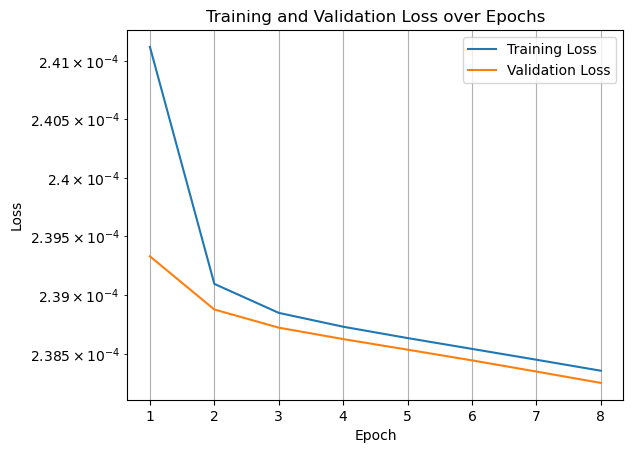

In [27]:
# Training loop
num_epochs = 8

fine_tune = False
if fine_tune:
    num_epochs = 4
    lr = 1e-4
    wd = 0
    ss = 1
    gamma = 0.75

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=128)
    
    val_loss = evaluate(model, test_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save model weights after each epoch
    epoch_save_path = f'{save_path[:-4]}_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), epoch_save_path)
    print(f"Model weights saved to {epoch_save_path}")

    # Step the scheduler
    scheduler.step(val_loss)

timestamp = datetime.now().strftime('%y%m%d-%H%M%S')
# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Set the y-axis to log scale
plt.savefig(f'loss_plot_L2_{timestamp}.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [28]:
# Save the model weights at the end of training
# save_model(model, save_path)sdasdasdas
save_path_posttraining = f'{save_path[:-4]}_e{len(train_losses)}.pth'
torch.save(model.state_dict(), save_path_posttraining)
print(f"Saved model weights to {save_path_posttraining}")

# Save the training and validation losses
losses_save_path = f'{save_path[:-4]}_e{len(train_losses)}_losses.pkl'
losses_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses
}
import pickle
with open(losses_save_path, 'wb') as f:
    pickle.dump(losses_dict, f)
print(f"Saved training and validation losses to {losses_save_path}")



Saved model weights to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_e8.pth
Saved training and validation losses to ./bcdr_f16_L2SGD_hc128_lr1e-02_wd0e+00_ss1_gamma9e-01_e8_losses.pkl


In [29]:
def plot_sample(data, title, labels, shared_colorbar=False, vmin=None, vmax=None, layout=None, save=False, save_path='plot.png'):
    try:
        # Automatically select layout based on the number of data arrays if not provided
        num_arrays = data.shape[0]
        if layout is None:
            if num_arrays == 3:
                layout = (1, 3)
            elif num_arrays == 4:
                layout = (2, 2)
            else:
                raise ValueError("Data input must have 3 or 4 arrays for plotting.")

        # Adjust figure size based on layout
        if layout == (1, 3):
            fig, axes = plt.subplots(*layout, figsize=(12, 4))  # Wide and short for 1x3 layout
        elif layout == (2, 2):
            fig, axes = plt.subplots(*layout, figsize=(8, 8))   # Square for 2x2 layout
        else:
            raise ValueError("Unsupported layout")

        for ax, (idx, label) in zip(axes.flatten(), labels):
            im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
            ax.set_title(label)
            if not shared_colorbar:
                fig.colorbar(im, ax=ax)

        if shared_colorbar:
            # Add a single colorbar to the right of the plot
            cbar = fig.colorbar(im, ax=axes.ravel().tolist())
            cbar.ax.set_ylabel('Color scale')

        plt.suptitle(title)

        if save:
            # Save the figure
            plt.savefig(save_path)
            print(f"Plot saved at {save_path}")
            plt.close(fig)
        else:
            # Display the figure
            plt.show()
    except Exception as e:
        print(f"Error in plot_sample: {e}")

def plot_inputs(data, title, labels, save=False, save_path='example_plot.png'):
    try:
        # Plot inputs with layout (1, 3) and custom figure size
        plot_sample(data, title, labels, shared_colorbar=True, layout=(1, 3), save=save, save_path=save_path)
    except Exception as e:
        print(f"Error in plot_inputs: {e}")

def plot_predictions_and_targets(inputs_tuple, outputs, targets, save=False, save_dir='figures/', file_suffix='example'):
    try:
        # Ensure save directory exists if save is True
        if save:
            os.makedirs(save_dir, exist_ok=True)

        # Add file_suffix to the filenames
        input_filename = f'{save_dir}/input_{file_suffix}.png'
        output_filename = f'{save_dir}/output_{file_suffix}.png'
        target_filename = f'{save_dir}/target_{file_suffix}.png'

        # Unpack the inputs tuple (geometry, waveform, band)
        geometry, waveform, band = inputs_tuple
        
        # Stack the inputs for plotting
        inputs_stacked = torch.stack([geometry, waveform, band], dim=0)
        
        input_labels = [(0, 'geometry'), (1, 'wavevectors'), (2, 'band')]
        plot_inputs(inputs_stacked, 'Inputs', input_labels, save=save, save_path=input_filename)

        # Compute global min and max for shared colorbar between outputs and targets
        vmin = min(np.min(outputs.cpu().numpy()), np.min(targets.cpu().numpy()))
        vmax = max(np.max(outputs.cpu().numpy()), np.max(targets.cpu().numpy()))

        # Create a 2x4 layout for predictions and targets with wider figure to accommodate colorbar
        fig, axes = plt.subplots(2, 4, figsize=(18, 8))
        
        # Labels for each channel
        channel_labels = ['eigenvector_x_real', 'eigenvector_x_imag', 'eigenvector_y_real', 'eigenvector_y_imag']
        
        # Plot predictions in the first row
        for i in range(4):
            im = axes[0, i].imshow(outputs[i, :, :].cpu(), cmap='viridis', vmin=vmin, vmax=vmax)
            axes[0, i].set_title(f'Pred: {channel_labels[i]}')
        
        # Plot targets in the second row
        for i in range(4):
            im = axes[1, i].imshow(targets[i, :, :].cpu(), cmap='viridis', vmin=vmin, vmax=vmax)
            axes[1, i].set_title(f'Target: {channel_labels[i]}')
        
        # Adjust layout to make room for colorbar
        plt.subplots_adjust(right=0.85)
        
        # Add a shared colorbar
        cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.ax.set_ylabel('Color scale')
        
        plt.suptitle('Model Predictions vs Targets')

        if save:
            # Save the combined figure
            combined_filename = f'{save_dir}/predictions_vs_targets_{file_suffix}.png'
            plt.savefig(combined_filename, bbox_inches='tight')
            print(f"Combined plot saved at {combined_filename}")
            plt.close(fig)
        else:
            # Display the figure
            plt.show()
    except Exception as e:
        print(f"Error in plot_predictions_and_targets: {e}")


Batch indices shape: torch.Size([256])
Training sample index: 6884078
Geometry index: 38244, Waveform index: 56, Band index: 3
Sample loss: 0.00023765


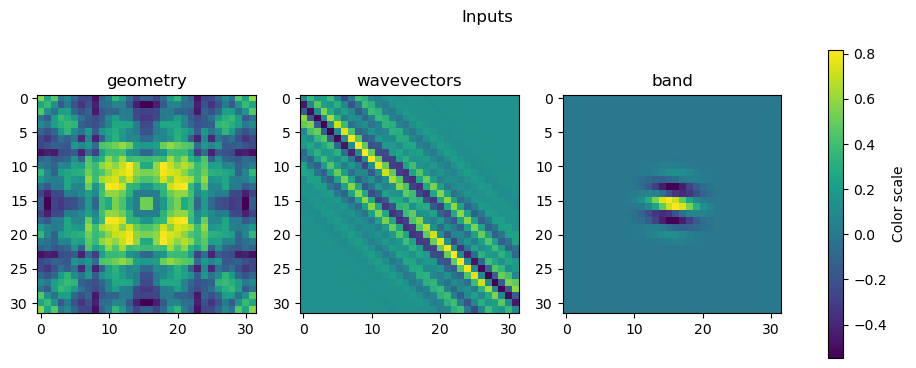

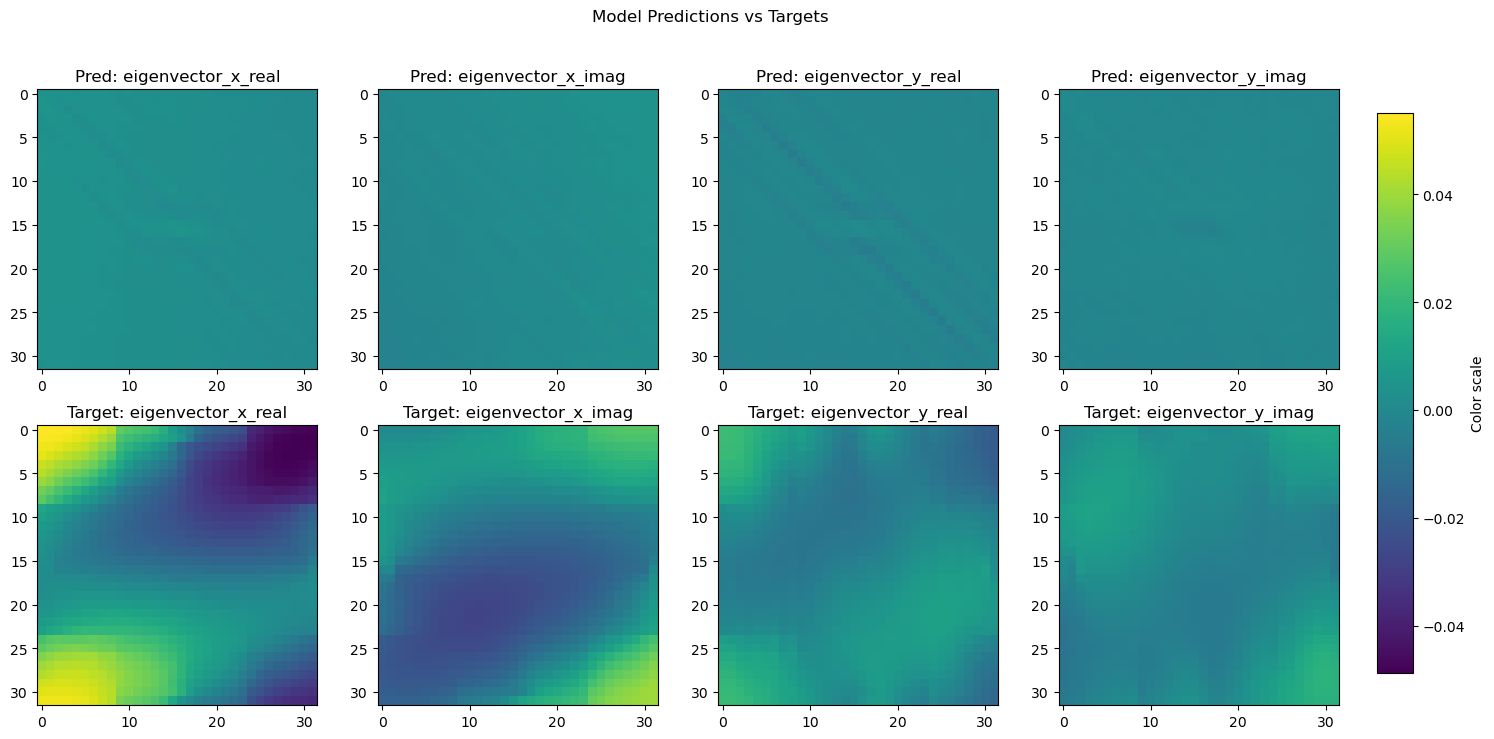

In [24]:
# Get a batch from the validation loader
batch_indices, = next(iter(test_loader))  # Note the comma - batch_indices is a tuple
print(f"Batch indices shape: {batch_indices.shape}")

sample_idx = np.random.randint(0, len(batch_indices))
if sample_idx >= len(batch_indices):
    sample_idx = 1  # Use first sample if 42 is out of range

# Get the training sample index
training_sample_idx = batch_indices[sample_idx]
print(f"Training sample index: {training_sample_idx}")

# Get the mapping indices
geometry_idx, waveform_idx, band_idx = combined_reduced_indices[training_sample_idx]
print(f"Geometry index: {geometry_idx}, Waveform index: {waveform_idx}, Band index: {band_idx}")

# Fetch the actual data
geometry_sample = combined_geometries[geometry_idx]
waveform_sample = waveforms[waveform_idx]
band_sample = band_ffts[band_idx]
target_sample = combined_displacements[training_sample_idx]

# Move to device
geometry_sample = geometry_sample.to(device)
waveform_sample = waveform_sample.to(device)
band_sample = band_sample.to(device)
target_sample = target_sample.to(device)

# Combine inputs for visualization
input_sample = torch.stack([geometry_sample, waveform_sample, band_sample], dim=0)

# Run the model to get predictions
model.eval()
with torch.no_grad():
    # Assuming your model takes a combined input tensor
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)  # Add batch dim, then remove it
    sample_loss = criterion(output_sample.unsqueeze(0), target_sample.unsqueeze(0))
    print(f"Sample loss: {sample_loss.item():.8f}")

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)


In [25]:
def plot_model_weights_histogram(model, log_scale=False, print_analytics=False):
    """
    Plots a histogram of the weight values of a given model.
    
    Parameters:
        model: The model object (e.g., PyTorch or TensorFlow model).
        log_scale (bool): If True, the y-axis of the histogram is set to logarithmic scale.
        print_analytics (bool): If True, prints the mean, standard deviation, and total number of weights.
    """
    # Extract all weight values
    weights = []

    # For PyTorch model
    if hasattr(model, "parameters"):
        for param in model.parameters():
            if param.requires_grad:  # Focus only on trainable parameters
                weights.append(param.data.cpu().numpy().flatten())

    # For TensorFlow/Keras model
    elif hasattr(model, "trainable_weights"):
        for layer_weights in model.trainable_weights:
            weights.append(layer_weights.numpy().flatten())

    else:
        raise ValueError("Unsupported model type. The model must be a PyTorch or TensorFlow model.")

    # Flatten and concatenate all weights into a single array
    all_weights = np.concatenate(weights)

    # Print analytics if the flag is set
    if print_analytics:
        mean = np.mean(all_weights)
        std_dev = np.std(all_weights)
        total_weights = all_weights.size
        print(f"Model Weight Analytics:")
        print(f"  Mean: {mean:.4f}")
        print(f"  Standard Deviation: {std_dev:.4f}")
        print(f"  Total Number of Weights: {total_weights}")

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=100, alpha=0.75, color='blue', edgecolor='black')
    plt.title("Histogram of Model Weight Values")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")

    if log_scale:
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.ylabel("Frequency (log scale)")

    plt.grid(axis='y', alpha=0.75)
    plt.show()

Model Weight Analytics:
  Mean: 0.0000+0.0000j
  Standard Deviation: 0.0063
  Total Number of Weights: 35852932


c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\numpy\lib\histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\hz283\AppData\Local\anaconda3\envs\NO_2D_Metamaterials\Lib\site-packages\matplotlib\axes\_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


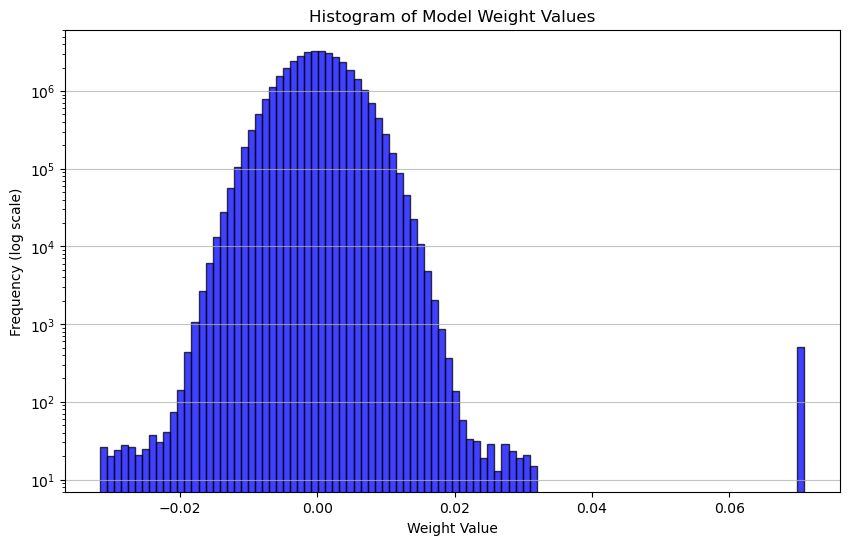

In [16]:
plot_model_weights_histogram(model, log_scale=True, print_analytics=True)

In [17]:
# initialized_model = FourierNeuralOperator(modes_height=design_res, 
#                                           modes_width=design_res, 
#                                           in_channels=3, 
#                                           out_channels=4, 
#                                           hidden=hc,
#                                           num_layers=4).to(device)

In [18]:
#plot_model_weights_histogram(initialized_model, log_scale=True, print_analytics=True)

## Calculate losses on test dataset using average absolute error to give a training loss agnostic representation of performance

In [19]:
# # Set model to evaluation mode
# model.eval()

# # Initialize running statistics
# running_error_sum = 0
# running_error_sq_sum = 0
# running_l1_loss = 0
# running_count = 0
# min_pixel = float('inf')
# max_pixel = float('-inf')
# pixel_sum = 0

# with torch.no_grad():
#     for data, target in tqdm(val_loader, desc="Evaluating"):
#         # Move data to device if using GPU
#         data, target = data.to(device), target.to(device)
        
#         # Get model predictions
#         output = model(data)
        
#         # Calculate absolute percentage error for each pixel
#         abs_perc_error = torch.abs((output - target) / (target + 1e-8)) * 100
        
#         # Calculate batch statistics
#         batch_error = torch.mean(abs_perc_error, dim=(1,2,3))  # Average over all dimensions except batch
        
#         # Update running statistics on GPU
#         running_error_sum += torch.sum(batch_error)
#         running_error_sq_sum += torch.sum(batch_error ** 2)
#         running_l1_loss += torch.nn.functional.l1_loss(output, target) * target.size(0)
#         running_count += target.size(0)  # Count number of samples, not pixels
        
#         # Update pixel statistics on GPU
#         min_pixel = min(min_pixel, target.min().item())
#         max_pixel = max(max_pixel, target.max().item()) 
#         pixel_sum += target.sum().item()

# # Calculate final statistics
# mean_error = (running_error_sum / running_count).cpu().item()
# std_error = torch.sqrt(running_error_sq_sum/running_count - (running_error_sum/running_count)**2).cpu().item()
# mean_l1_loss = (running_l1_loss / len(val_loader.dataset)).cpu().item()
# mean_pixel = pixel_sum / (running_count * target.size(1) * target.size(2) * target.size(3))

# print(f"Test Set Statistics:")
# #print(f"Average Sample Percentage Error: {mean_error:.2f}% ± {std_error:.2f}%")
# print(f"Average L1 Loss: {mean_l1_loss:.6f}")
# print(f"\nDataset Pixel Value Statistics:")
# print(f"Min: {min_pixel:.6f}")
# print(f"Mean: {mean_pixel:.6f}")
# print(f"Max: {max_pixel:.6f}")